Task 1 [40 points]: Implementation of Power Iteration Algorithm.

Task 1(A) [25 points] Implement the power iteration algorithm in matrix form to calculate the rank vector r, without teleport, using the PageRank formulation:
r(t+1) = M · r(t)
The matrix M is an adjacency matrix representing nodes and edges from your downloaded dataset, with rows representing destination nodes and columns representing source nodes. This matrix is sparse2. Initialize r(0) = [1/N, . . . , 1/N]T . Let the stop criteria of your power iteration algorithm be ||r(t+1) − r(t)||1 < 0.02 (please note the stop criteria involves the L1 norm). Spider traps and dead ends are not considered in this first task.
Task 1(B) [15 points] Run your code on the Berkeley-Stanford web data to calculate the rank score for all the nodes. Report: (1) The running time of your power iteration algorithm; (2) The number of iterations needed to stop; (3) The IDs and scores of the top-10 ranked nodes.

In [6]:
import numpy as np
import time
from scipy.sparse import csc_matrix
start_time = time.time()
# 1. Read data and create sparse adjacency matrix
edges = []
with open("web-BerkStan-final.txt", "r") as file:
    for line in file:
        src, dest = map(int, line.strip().split())
        edges.append((src, dest))
nodes = set(src for src, _ in edges).union(dest for _, dest in edges)
# N is the number of nodes
N = len(nodes)
print("Node number: ",N)
mapping = {node: i for i, node in enumerate(nodes)}
data = [1] * len(edges)
rows = [mapping[src] for src, _ in edges]
cols = [mapping[dest] for _, dest in edges]
adj_matrix = csc_matrix((data, (rows, cols)), shape=(len(nodes), len(nodes)))
column_sums = np.array(adj_matrix.sum(axis=0)).flatten()
non_zero_cols = column_sums != 0
adj_matrix.data = adj_matrix.data.astype(float)
adj_matrix.data /= np.repeat(column_sums[non_zero_cols], np.diff(adj_matrix.indptr)[non_zero_cols])
# print("M is: ",adj_matrix.toarray())
def power_iteration(M,N, tol=0.02, max_iter=1000):
    # rank vector 0
    r_prev = np.ones([N,1]) / N
    convergence_history = []
    for i in range(max_iter):
        r_next  = M.dot(r_prev)

        diff = np.linalg.norm(r_next - r_prev, ord=1)
        convergence_history.append(diff)

        if diff < tol:
            return r_next, convergence_history, i+1
        
        r_prev = r_next
            
    return r_prev, convergence_history, i+1
# run the power iteration and time it
result_vector, convergence, iterations = power_iteration(adj_matrix,N)
end_time = time.time()
# Flatten the result_vector before getting top indices
flattened_vector = result_vector.flatten()
# print("Convergence: ",convergence)
#calculate the time
runtime = end_time - start_time
print("Time: ",runtime)
# Get top 10 pages' ID and value using the flattened vector
top_10_indices_flattened = np.argsort(flattened_vector)[-10:][::-1]
top_10_scores_flattened = flattened_vector[top_10_indices_flattened]
top_10_ids_flattened = [list(mapping.keys())[list(mapping.values()).index(i)] for i in top_10_indices_flattened]

print("Iteration number: ",iterations)
print("Top-10 ranked nodes:")

for id, score in zip(top_10_ids_flattened, top_10_scores_flattened):
    print("ID:", id, "| Score:", score)

Node number:  685230
Time:  6.059493064880371
Iteration number:  138
Top-10 ranked nodes:
ID: 442556 | Score: 0.0010666956320281834
ID: 163117 | Score: 0.0008493475584414149
ID: 272964 | Score: 0.0008446241966053856
ID: 523251 | Score: 0.000745468329737256
ID: 523252 | Score: 0.000745468329737256
ID: 363570 | Score: 0.0006852949219489149
ID: 364215 | Score: 0.0006852949219489149
ID: 625464 | Score: 0.0006681603359228974
ID: 625472 | Score: 0.000584674696229415
ID: 387032 | Score: 0.0005766581439203694


Task 2(A) Calculate and report the number of dead-end nodes in your matrix M.

In [3]:
# column_sums = adj_matrix.sum(axis=0)
# dead_end_indices = np.where(column_sums == 0)[1]
row_sums = np.array(adj_matrix.sum(axis=1)).flatten()
dangling_nodes = np.where(row_sums == 0)[0]

print("Dead-end indices: ",dangling_nodes)
num_dead_ends = len(dangling_nodes)
print("Number of dead-end nodes:", num_dead_ends)

Dead-end indices:  [   817    873    885 ... 683579 684754 685100]
Number of dead-end nodes: 4744


Task 2(B) Calculate the leaked PageRank score in each iteration of Task 1(B)

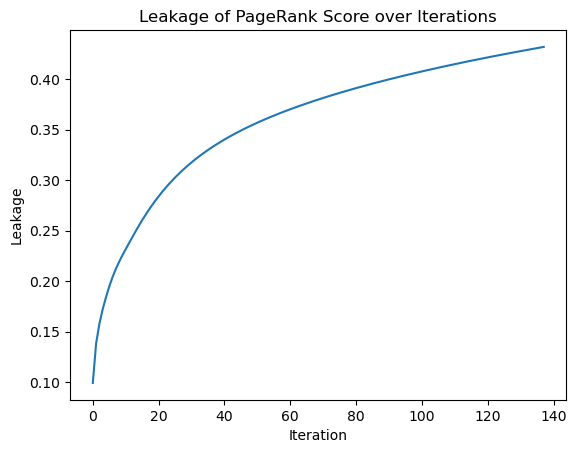

In [8]:
def power_iteration_with_leakage(M, N, tol=0.02, max_iter=1000):
    r_prev = np.ones([N,1]) / N
    convergence_history = []
    leakage_history = []
    
    for i in range(max_iter):
        r_next = M.dot(r_prev)
        # Calculate leakage
        leakage = 1.0 - np.sum(r_next)
        leakage_history.append(leakage)
        
        diff = np.linalg.norm(r_next - r_prev, ord=1)
        convergence_history.append(diff)

        if diff < tol:
            return r_next, convergence_history, leakage_history, i+1
        
        r_prev = r_next
            
    return r_prev, convergence_history, leakage_history, i+1

# Run the function
result_vector_leakage, convergence_leakage, leakage, iterations_leakage = power_iteration_with_leakage(adj_matrix, N)
import matplotlib.pyplot as plt

plt.plot(leakage)
plt.title('Leakage of PageRank Score over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Leakage')
plt.show()


Task3 [50 points]: Implementation of Power Iteration with Teleport.
Task 3(A): Extend your PageRank code to handle both spider traps and dead ends using the idea of teleport. In this task, your implementation will allow to teleport randomly to any node. Code the PageRank with teleport formulation that, using the sparse matrix M, for each iteration works in three steps

In [1]:
def power_iteration_with_teleport(M, N, beta=0.9, tol=0.02, max_iter=1000):
    # Initialize r
    r_prev = np.ones([N, 1]) / N
    convergence_history = []

    for i in range(max_iter):
        # Step 1: calculate r_new
        r_new = beta * M.dot(r_prev)

        # Step 2: calculate S
        S = np.sum(r_new)

        # Step 3: update r_new with teleport
        r_new += (1 - S) / N

        # Check convergence
        diff = np.linalg.norm(r_new - r_prev, ord=1)
        convergence_history.append(diff)
        if diff < tol:
            return r_new, convergence_history,i+1

        r_prev = r_new

    return r_prev, convergence_history,i+1

Task 3(B) Run your code on the Berkeley-Stanford web data to calculate the rank score for all the nodes. Report: (1) The running time; (2) The number of iterations needed to stop; (3) The IDs and scores of the top-10 ranked nodes.

In [2]:
import time
import numpy as np
from scipy.sparse import csc_matrix, diags

from scipy.sparse import lil_matrix, csr_matrix
import numpy as np
start_time = time.time()
# Initialize an empty list to hold edges
edges = []

# Read data from file and append to the edges list
with open("web-BerkStan-final.txt", "r") as file:
    for line in file:
        src, dest = map(int, line.strip().split())
        edges.append((src, dest))
nodes = set(src for src, _ in edges).union(dest for _, dest in edges)
# N is the number of nodes
N = len(nodes)
print("Node number: ",N)
mapping = {node: i for i, node in enumerate(nodes)}
data = [1] * len(edges)
rows = [mapping[src] for src, _ in edges]
cols = [mapping[dest] for _, dest in edges]
adj_matrix = csc_matrix((data, (rows, cols)), shape=(len(nodes), len(nodes)))
column_sums = np.array(adj_matrix.sum(axis=0)).flatten()
non_zero_cols = column_sums != 0
adj_matrix.data = adj_matrix.data.astype(float)
adj_matrix.data /= np.repeat(column_sums[non_zero_cols], np.diff(adj_matrix.indptr)[non_zero_cols])

# run the power iteration and time it
result_vector_teleport, iterations_teleport, iterations_teleport = power_iteration_with_teleport(adj_matrix, N)
end_time = time.time()
# Flatten the result_vector before getting top indices
flattened_vector_teleport = result_vector_teleport.flatten()
# Print("Convergence: ",convergence_teleport)
# Calculate the time
runtime = end_time - start_time
print("Time: ",runtime)
# Get top 10 pages' ID and value using the flattened vector
top_10_indices_flattened = np.argsort(flattened_vector_teleport)[-10:][::-1]
top_10_scores_flattened = flattened_vector_teleport[top_10_indices_flattened]
top_10_ids_flattened = [list(mapping.keys())[list(mapping.values()).index(i)] for i in top_10_indices_flattened]

print("Iteration number: ",iterations_teleport)
print("Top-10 ranked nodes:")

for id, score in zip(top_10_ids_flattened, top_10_scores_flattened):
    print("ID:", id, "| Score:", score)

Node number:  685230
Time:  5.174262046813965
Iteration number:  14
Top-10 ranked nodes:
ID: 41050 | Score: 0.0023221309826442055
ID: 262975 | Score: 0.001514408027392803
ID: 272964 | Score: 0.0013396219264278008
ID: 259983 | Score: 0.001289156878437989
ID: 25146 | Score: 0.0011903067611371831
ID: 950 | Score: 0.0011326853481111797
ID: 967 | Score: 0.00112202128959908
ID: 973 | Score: 0.0006842806972386029
ID: 702 | Score: 0.0006479776025043144
ID: 163117 | Score: 0.0006034622428239366


Task 3(C) Vary the teleport probability β with numbers in the set: {1, 0.9, 0.8, 0.7, 0.6}. Report the number of iterations needed to stop for each β. Explain, in words, your findings from this experiment.

In [3]:
betas = [1, 0.9, 0.8, 0.7, 0.6]
iterations_for_betas = []

for beta in betas:
    _, _, iterations = power_iteration_with_teleport(adj_matrix, N, beta=beta)
    iterations_for_betas.append(iterations)

# Print the results
for beta, iterations in zip(betas, iterations_for_betas):
    print(f"For beta = {beta}, number of iterations = {iterations}")


For beta = 1, number of iterations = 131
For beta = 0.9, number of iterations = 14
For beta = 0.8, number of iterations = 9
For beta = 0.7, number of iterations = 6
For beta = 0.6, number of iterations = 5


leakage: 5.551115123125783e-16
leakage: -2.220446049250313e-16
leakage: 6.661338147750939e-16
leakage: -2.220446049250313e-16
leakage: 2.220446049250313e-16
leakage: 3.3306690738754696e-16
leakage: -1.1102230246251565e-15
leakage: 1.1102230246251565e-16
leakage: 6.661338147750939e-16
leakage: 2.220446049250313e-16
leakage: 0.0
leakage: 3.3306690738754696e-16
leakage: -2.220446049250313e-16
leakage: 4.440892098500626e-16
iterations_leakage 14


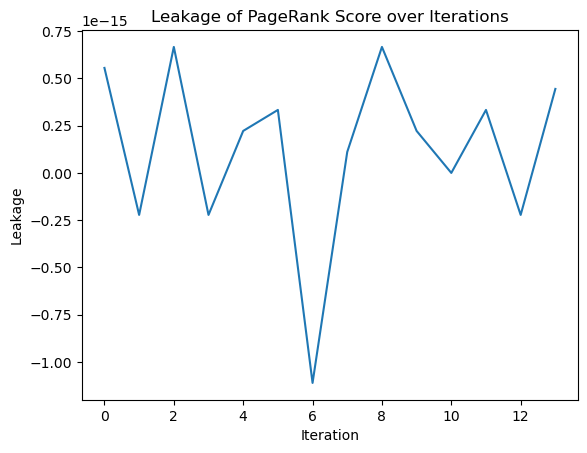

In [4]:
def power_iteration_with_teleport_leak(M, N, beta=0.9, tol=0.02, max_iter=1000):
    # 初始化 r
    r_prev = np.ones([N, 1]) / N
    convergence_history = []
    leakage_history = []

    for i in range(max_iter):
        # Step 1: calculate r_new
        r_new = beta * M.dot(r_prev)

        # Step 2: calculate S
        S = np.sum(r_new)

        # Step 3: update r_new with teleport
        r_new += (1 - S) / N
        
        leakage = 1.0 - np.sum(r_new)
        print("leakage:",leakage)
        leakage_history.append(leakage)

        # Check convergence
        diff = np.linalg.norm(r_new - r_prev, ord=1)
        convergence_history.append(diff)
        if diff < tol:
            return r_new, convergence_history, leakage_history, i+1

        r_prev = r_new

    return r_prev, convergence_history, leakage_history, i+1

# Run the function
result_vector_leakage, convergence_leakage, leakage, iterations_leakage = power_iteration_with_teleport_leak(adj_matrix, N)
print("iterations_leakage",iterations_leakage)
# Plotting
import matplotlib.pyplot as plt

plt.plot(leakage)
plt.title('Leakage of PageRank Score over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Leakage')
plt.show()


验证

In [19]:
import numpy as np
import time
from scipy.sparse import csc_matrix
start_time = time.time()
# 1. Read data and create sparse adjacency matrix
edges = []
with open("web-BerkStan-final.txt", "r") as file:
    for line in file:
        src, dest = map(int, line.strip().split())
        edges.append((src, dest))
nodes = sorted(list(set(src for src, _ in edges).union(dest for _, dest in edges)))
# N is the number of nodes
N = len(nodes)
print("Node number: ",N)
mapping = {node: i for i, node in enumerate(nodes)}
data = [1] * len(edges)
rows = [mapping[src] for src, _ in edges]
cols = [mapping[dest] for _, dest in edges]
adj_matrix = csc_matrix((data, (rows, cols)), shape=(len(nodes), len(nodes)))
transposed_matrix = adj_matrix.T
column_sums = np.array(transposed_matrix.sum(axis=0)).flatten()
print("column_sums is: ",column_sums)
non_zero_cols = column_sums != 0
transposed_matrix.data = transposed_matrix.data.astype(float)
transposed_matrix.data /= np.repeat(column_sums[non_zero_cols], np.diff(transposed_matrix.indptr)[non_zero_cols])

print("adj_matrix is: ",adj_matrix.toarray())
print("M is: ",transposed_matrix.toarray())
def power_iteration(M,N, tol=0.02, max_iter=1000):
    # rank vector 0
    r_prev = np.ones([N,1]) / N
    convergence_history = []
    for i in range(max_iter):
        r_next  = M.dot(r_prev)

        diff = np.linalg.norm(r_next - r_prev, ord=1)
        convergence_history.append(diff)

        if diff < tol:
            return r_next, convergence_history, i+1
        
        r_prev = r_next
        print("r_prev is: ",r_prev)
        print("iteration is: ",i+1)
            
    return r_prev, convergence_history, i+1
# run the power iteration and time it
result_vector, convergence, iterations = power_iteration(transposed_matrix,N)
end_time = time.time()
# Flatten the result_vector before getting top indices
flattened_vector = result_vector.flatten()
# print("Convergence: ",convergence)
#calculate the time
runtime = end_time - start_time
print("Time: ",runtime)
# Get top 10 pages' ID and value using the flattened vector
top_10_indices_flattened = np.argsort(flattened_vector)[-10:][::-1]
top_10_scores_flattened = flattened_vector[top_10_indices_flattened]
top_10_ids_flattened = [list(mapping.keys())[list(mapping.values()).index(i)] for i in top_10_indices_flattened]

print("Iteration number: ",iterations)
print("Top-10 ranked nodes:")

for id, score in zip(top_10_ids_flattened, top_10_scores_flattened):
    print("ID:", id, "| Score:", score)

FileNotFoundError: [Errno 2] No such file or directory: 'web-BerkStan-final.txt.txt'